In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple

In [2]:
#Debuger
from IPython.core.debugger import set_trace

For **getting help** about parameters and return results:

`help(function_you_dont_know)`  
or use numpy info function   
`np.info(function_you_dont_know)`

In [3]:
class Neuron:    
    """ Neuron Utility handlers """
    @staticmethod
    def integrate(U, I, dt, config):
        """
            Calculate next potentials list based on last potentials and Currents input which neurons get
            Cause numpy brodcasting ability, functions may work correct for single entry for ndarrays 

            Keyword arguments:
            U -- potentials array <numpy.ndarray>
            I -- current stands for internat and extrenal currents which every neurons recives <numpy.ndarray>
            dt -- time step for each step <float>
            config -- A matrix containg configuration for each of neurons <numpy.ndarray>
                      it must [u_rest, R, threshold, tau] it use array keyword referencing.
            
            return:
            a tuple that contains (potentials, spikedActivity)
            potentials -- new potentials calculated based on Leaky integrated and fire dynamics <numpu.ndarray>
            spikedActivity -- boolean array which shows wheter neuron spiked in this step or not <numpy.ndarray>
        """
        u_rest = config['u_rest']

        potentials = U + ((u_rest - U) + config['R'] * I) * (dt / config['tau'])
        potentials[potentials >= config['threshold']] = u_rest
        return potentials, potentials == u_rest
        
    @staticmethod
    def generate_config(tau=5, resistor=5, threshold=-65, uRest=-70, size=None, noise=None):
        """ 
            generate configuration for variables make them noisy in if args presented

            Keyword arguments:
            tau -- time constant for decays (default=5)
            resistor -- (default=5)
            threshold -- (default=-65)
            uRest -- (default=-70)
            size -- size of configuration (default=None)
            noise -- setup for adding noise to configuration, make them not be exactly the same 
                    { size, mu, sigma } (default=None)
                    mu -- mean of distribution (default=0)
                    sigma -- standrad variation of distribution (default=1)

            return: configurations

            TODO: accept None in noise to prevent gauusain noise around specifi varibale
            TODO: accpet diffrent configs for noise parameter, make it possible to have diffrent noise for diffrent configs 
            TODO: move noise to higger level use case, and keep pop homogenous 
            TODO: setup dtype optimization for lower memory allocation  
        """

        if noise is None or size is None:
            return np.array(
                (tau, resistor, threshold, uRest), 
                dtype=[('tau', 'f8'), ('R', 'f8'), ('threshold', 'f8'), ('u_rest', 'f8')]
            )
        
        # noise generator from gaussian normal distribution
        n = lambda v: v + np.random.normal(noise.get('mu', 0), noise.get('sigma', 1), size)
        return {
            'tau': n(tau),
            "R": n(resistor),
            "threshold": n(threshold),
            'u_rest': uRest
        }


# Weight dependence: hard bounds and soft bounds

For biological reasons, it is desirable to keep the synaptic weights in a range $w_{min} < w_j < w_{max}$ 

In [43]:
class Utils:
    @staticmethod
    def clamp(value, minimum=None, maximum=None):
        """
            Clamp entry value between specified bound, no clamp will be done if bound is not specifeid
            Cause numpy brodcasting ability, functions may work correct for single entry for ndarrays
            Do it inplace and will change entry value

            Keyword arguments:
            value -- Values which gonna be clamped <numpy.ndarray>
            minimum -- lower bound (default=None)
            maximum -- upper bound (default=None)
            
            updated value can be used
        """

        if (minimum is not None):
            value[value < minimum] = minimum
        if (maximum is not None):
            value[value > maximum] = maximum

    @staticmethod
    def soft_bound_Ap(w, w_max=1, nu_positive=0.3):
        """
            soft bound function for updating Weigths by A+(amplitude parameter) in stdp learnging

            Keyword arguments:
            w -- weights <numpy.ndarray>
            w_max -- maximum value can w reach, it cause lower update in for close weigths (default=1)
            nu_positive -- rating parameters for updaing weigths (deafult=0.3)

            return: Wmax - w * η+
        """

        return (w_max - w) * nu_positive
    
    @staticmethod
    def soft_bound_An(w,  w_min=0, nu_negative=0.2):
        """
            soft bound function for updating Weigths by A-(amplitude parameter) in stdp learnging

            Keyword arguments:
            w -- weights <numpy.ndarray>
            nu_negative -- rating parameters for updaing weigths (deafult=0.2)

            return: (w - w_min) * η-
        """

        return (w - w_min) * nu_negative

In [49]:
class Connection:
    """ 
        Connect population A to population B with connection_type strategy
            full or full_connectivity,
            fixedCP or fixed_coupling_probability_connectivity,
            fixedNPP or fixed_number_of_presynaptics_parents,

        Keyword arguments:
        A -- size of pre-population <int>
        B -- size of post-pospulation <int>
        ------------------------------------
        p -- coupling_probability (default=0.1)
        J0 -- TODO:
        r0 -- TODO:

        TODO: For illiminate performance issue it doesn't connect neurons until calling @method for comp
        TODO: Documentaion must be added in this case
    """
    @staticmethod
    def full_connectivity(A, B, p=1, J0=10, r0=1, wMax=None, wMin=None): 
        pre_indexes, post_indexes = range(A), range(B)

        C = p * A # p * N
        assert C != 0, 'Check size of your pre-poulation size, or increase p (No Devision by Zero)'
        μ, σ = J0/C, r0/math.sqrt(C)
        normal = np.random.normal
        relations = []

        for pre in pre_indexes:
            for post in post_indexes:
                relations.append((pre, post, normal(μ, σ)))
        
        connections = Connection.set_relations(relations)
        if (wMin is not None or wMax is not None):
            Utils.clamp(connections['w'], wMin, wMax)
        return connections

    @staticmethod
    def fixed_coupling_probability_connectivity(A, B, p=0.1, J0=10, r0=1, wMax=None, wMin=None): 
        pre_indexes, post_indexes = range(A), range(B)

        CA = p * A
        assert CA != 0, 'Check size of your pre-poulation size, or increase p (No Devision by Zero)'
        CB = p * B
        assert CB != 0, 'Check size of your post-poulation size, or increase p (No Devision by Zero)'
        μ, σ = J0/CB, r0/math.sqrt(CB)
        normal = np.random.normal
        relations = []

        for pre in np.random.choice(pre_indexes, int(CA), replace=False):
            for post in np.random.choice(post_indexes, int(CB), replace=False):
                relations.append((pre, post, normal(μ, σ)))

        connections = Connection.set_relations(relations)
        if (wMin is not None or wMax is not None):
            Utils.clamp(connections['w'], wMin, wMax)
        return connections

        
    @staticmethod
    def fixed_number_of_presynaptics_parents_connectivity(A, B, p=0.1, J0=10, r0=1, wMax=None, wMin=None): 
        pre_indexes, post_indexes = range(A), range(B)
        C = p * A
        assert C != 0, 'Check size of your pre-poulation size, or increase p (No Devision by Zero)'
        μ, σ = J0/C, r0/math.sqrt(C)
        normal = np.random.normal
        relations = []

        for post in post_indexes:
            for pre in np.random.choice(pre_indexes, int(C), replace=False):
                relations.append((pre, post, normal(μ, σ)))

        connections = Connection.set_relations(relations)
        if (wMin is not None or wMax is not None):
            Utils.clamp(connections['w'], wMin, wMax)
        return connections

    @staticmethod
    def set_relations(relations):
        """
            Keyword arguments:
            relations -- relation connections <iterator with (pre_index, post_index, weight_for_connection)>
            return ndarray < pre, post, w >
            pre -- index of pre synaptic neurons
            post -- index of post synaptic neurons
            w -- weight for connections 

        """
        return np.array(
            relations,
            dtype=[('pre', np.uint16), ('post', np.uint16), ('w', np.float64)]
        )

    # short hand for connectivities
    full = full_connectivity.__func__
    fixedCP = fixed_coupling_probability_connectivity.__func__ 
    fixedNPP = fixed_number_of_presynaptics_parents_connectivity.__func__

In [131]:
class Learning:
    @staticmethod
    def stdp(t_pre, t_post, W,  **config):
        # TODO: Performace boost can be added make it classmethod or normal method
        # deafult values
        
        Δt =  t_post - t_pre
        Δw = np.empty_like(Δt)
        Δtp = Δt >= 0
        if np.any(Δtp):
            Ap    = config.get('Ap', Utils.soft_bound_Ap)
            τp  = config.get('taup', 0.03)
            w_max = config.get('wMax', 1)
            ηp = config.get('etap', 0.03) 
            Δw[Δtp] =  Ap(W[Δtp], w_max, ηp) * np.exp(-np.abs(Δt[Δtp]) / τp)  

        Δtn = Δt < 0
        if np.any(Δtn):
            An     = config.get('An', Utils.soft_bound_An)
            w_min = config.get('wMin', 0)
            τn   = config.get('taun', 0.02)
            ηn = config.get('etan', 0.02)
            # TODO: investigate signiture
            Δw[Δtn] =  An(W[Δtn], w_min, ηn) * np.exp(-np.abs(Δt[Δtn]) / τn)  
        # reset wrong spots for non spiked neurons
        Δw[t_post == -1] = 0
        Δw[t_pre == -1] = 0
        return Δw, Δt

In [132]:
class Population:
    """ 
        Gonna Handle homogenous population 

        Keyword argumetns:
        neuron -- Neuronal model LIF is implemented see:Neuron class
        neuron_configs -- dictionary that will spread to Neuron.generate_config function, see generate_config doc.
        **config -- extra aruments such as 
            timeStep -- dt <float> (default=0.1)
            hasInhibition -- <boolean> (deafult=False)
            duration --duration of process used for generating time series for process <float> (default=5)
            size -- number of neurons in this populations <int> (default=1000)
    """
    # 0.0 0.1 0.2 0.3 0.4 
    def __init__(self, neuron, neuron_configs={} ,**configs):
        self.dt = configs.get('timeStep', 0.1) 
        duration = configs.get('duration', 5)        
        self.time_series = np.arange(0, duration, self.dt)
        self.size = configs.get('size', 1000)
        self.isi = -1 ** int(configs.get('hasInhibition', False))

        self.potentials_series = np.empty((self.size, self.time_series.size))
        # Neurons (homogenous) SINGLE CONFIG 
        self.neuron_configs = Neuron.generate_config(**neuron_configs, size=self.size)
        # TODO: replace with empty (Caution it may cause bug in updating senario)
        self.last_spiked = np.ones(self.size) * -1
        # An currents input wich gonna update by connection weight change in learning process 
        self.I_internal = np.zeros(self.size)
        # initialize neurons potentials
        self.potentials_series[:, 0] = self.neuron_configs['u_rest']
    
    def activate(self, t, Iext=30):
        """ 
            Activate a population for one step 
            
            Keyword arguments:
            t -- time index 
            Iext --  (deafult=30)

            return: spiked_map
            
            TODO: need I_ext calculation from static fixed I ~ N(μ, σ), or separated for each individual
            TODO: I is now constant and not configured for pop (@critical) 
        """
        
        assert 1 <= t < self.time_series.size, 'Please Enter an integer belongs to [1, duration/dt) range as an index.'
        assert isinstance(Iext, float) or Iext.shape == self.I_internal.shape, 'Please Enter an integer belongs to [1, duration/dt) range as an index.'

        I = self.I_internal + Iext
        ut, spiked = Neuron.integrate(self.potentials_series[:, t - 1], I, self.dt, self.neuron_configs)
        # store last spiked time for neuron which spiked 
        self.last_spiked[spiked] = self.time_series[t]
        # update new potentials in time step t
        self.potentials_series[:, t] = ut
        # return spike
        return spiked

    def transmit_spike(self, indeces=None, weights=None, isi=1):
        """
            Transmit weights update effect to connected populations
            Keyword arguments:
            indeces -- indeces of neuron which going to update (deafult=None)
            weights -- weights of connections related to indeces (deafult=None)
            isi -- shows that updates are from inhibitory pop or excititory pop

            reset Tranmistion to its initial zero where one of indeces or weights are not passed to function
        """
        # reset to initial
        if indeces is None or weights is None:
            self.I_internal = np.zeros(self.size)
        else:
            self.I_internal[indeces] += isi * weights
    


In [184]:
config = {
    'duration': 500,
    'timeStep': 0.1,
}

neuron_configs = {
    'tau':5, 
    'resistor':5, 
    'threshold':-60, 
    'uRest':-75, 
    'noise':{'mu':0, 'sigma': 2}
}

stdp_config = {
    'wMax': 150,
    'wMin': -150,
    'taup': 0.3,
    'taun': 0.2,
    'etap': 0.3, 
    'etan': 0.2,
}

src = Population(Neuron, neuron_configs, size=1, hasInhibition=False, **config)
dest = Population(Neuron, neuron_configs, size=1, hasInhibition=True, **config)
connections = Connection.fixedNPP(src.size, dest.size, p=1, J0=10, r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
dw_dt = []

In [ ]:
assert src.time_series.size == dest.time_series.size, 'Time series are different in src and dest. (make sure duration and dt are the same in both populations)'

print("init w", connections['w'])
# loop over all time steps
for t in range(1, src.time_series.size):
    """
        update connection weights based on spiked trace
    """
    # reset Transmition effect in every time step
    dest.transmit_spike()    
    # PRE-POST::PRE SYNAPTIC FIRING -> WEIGHT UPDATES
    pre = np.where(src.activate(t))[0] # only row indeces (dont support mutli columns in one layer)
    if (pre.size):
        for activated_index in pre:
            involved_connections = connections[connections['pre']==activated_index]
            dw, dt = Learning.stdp(
                        src.last_spiked[involved_connections['pre']],
                        dest.last_spiked[involved_connections['post']],
                        involved_connections['w'],
                        **stdp_config
                    )
        
            connections['w'] -= dw
            Utils.clamp(connections['w'], stdp_config['wMin'], stdp_config['wMax'])
            dw_dt.append((t, -dw, dt, connections['w'].copy(), 'PRE'))
            #  update internal I
            dest.transmit_spike(involved_connections['post'], connections[connections['pre']==activated_index]['w'], src.isi)
    
    # POST-PRE::POST SYNAPTIC FIRING -> WEIGHT UPDATES
    post = np.where(dest.activate(t))[0] # only row indeces (dont support mutli columns in one layer)
    if (post.size):
        for activated_index in post:
            involved_connections = connections[connections['post']==activated_index]
            dw, dt = Learning.stdp(
                        src.last_spiked[involved_connections['pre']],
                        dest.last_spiked[involved_connections['post']],
                        involved_connections['w'],
                        **stdp_config
                    )
                  
            connections['w'] += dw
            Utils.clamp(connections['w'], stdp_config['wMin'], stdp_config['wMax'])

            dw_dt.append((t, dw, dt, connections['w'].copy(), 'POST'))
print("Final w", connections['w'])
dw_dt = np.array(dw_dt, dtype=[('t', np.uint16),('dw', np.float64),('dt', np.float32),('w', np.float64),('synaptic_type', '<U4')])

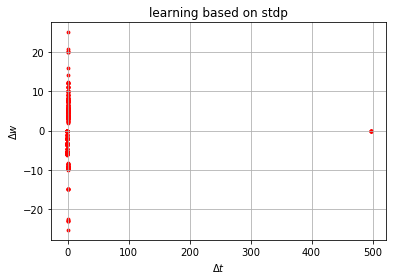

In [204]:
fig, ax = plt.subplots()
dt = dw_dt['dt']
dw = dw_dt['dw']
# prone and noise removal
plt.scatter(dt[dt < 100], dw[dt < 100], s=8, c="red")
ax.set(xlabel='$\Delta t$', ylabel='$\Delta w$',
       title='learning based on stdp')
ax.grid()
plt.savefig('name')

In [208]:
class Layer:
    def __init__(self, *args):
        self.__iterators = args

    def foreach(self, fn):
        for items in self.__iterators:
            fn(items)

In [217]:
stdp_config = {
    'wMax': 150,
    'wMin': -150,
    'taup': 0.3,
    'taun': 0.2,
    'etap': 0.3, 
    'etan': 0.2,
}

src = Population(Neuron, neuron_configs, size=10, hasInhibition=False, **config)
dest = Population(Neuron, neuron_configs, size=2, hasInhibition=False, **config)
connections = Connection.full(src.size, dest.size, J0=10, r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
dw_dt = []

In [ ]:
# run_stdp_cell in above

In [231]:
def geterate_pattern(pattern, high_ampitude=1000):
    pattern_duration = np.max(pattern)
    I = np.zeros((pattern.size, pattern_duration))
    for i in range(pattern_duration):
        I[:,i][pattern==i] = high_ampitude
    return pattern_duration, I

In [227]:
stdp_config = {
    'wMax': 150,
    'wMin': -150,
    'taup': 0.3,
    'taun': 0.2,
    'etap': 0.3, 
    'etan': 0.2,
}

src = Population(Neuron, neuron_configs, size=10, hasInhibition=False, **config)
dest = Population(Neuron, neuron_configs, size=2, hasInhibition=False, **config)
inhibition = Population(Neuron, neuron_configs, size=1, hasInhibition=True, **config)
src_dest = Connection.full(src.size, dest.size, J0=10, r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
src_inhibition = Connection.full(src.size, inhibition.size, J0=10, r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
inhibition_dest = Connection.full(inhibition.size, dest.size J0=10, r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
dw_dt = []

In [ ]:
# run_stdp_cell in above